In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.7 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import pandas as pd
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import zipfile
import requests
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pmdarima.arima import auto_arima
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm



In [3]:
FILE_NAME_CSV_DATASET_CLIMA = 'https://raw.githubusercontent.com/PabloSGomez50/humai-solar-panels/main/scraper_clima/clima_sydney_limpio3.csv'
FILE_NAME_CSV_DATASET_PRODUCCION = 'https://github.com/PabloSGomez50/humai-solar-panels/blob/main/dataset_produccion_energia/produccion.csv.zip?raw=true'

In [65]:
def get_dataset_clima():
  df_clima = pd.read_csv(FILE_NAME_CSV_DATASET_CLIMA)
  df_clima.drop(columns=['Unnamed: 0'], inplace = True)
  df_clima.rename(columns={'Date': 'Datetime'}, inplace = True)    

  # elimino dos registros que estaban duplicados
  dupli_1_index = df_clima[(df_clima.Datetime == '2013-04-07 02:00:00') & (df_clima.Barometer == 1023)].index
  dupli_2_index = df_clima[(df_clima.Datetime == '2013-04-07 02:30:00') & (df_clima.Barometer == 1023)].index
  df_clima = df_clima.drop(df_clima.index[dupli_1_index]).drop(df_clima.index[dupli_2_index]) 

  df_clima['Datetime'] = pd.to_datetime(df_clima['Datetime'], format='%Y-%m-%d %H:%M:%S')
  df_clima['Hora'] = df_clima.Datetime.dt.hour    
  df_clima['Mes'] = df_clima.Datetime.dt.month


  return df_clima

def get_dataset_produccion():
  content = requests.get(FILE_NAME_CSV_DATASET_PRODUCCION).content
  zip_file = zipfile.ZipFile(io.BytesIO(content))
  file = zip_file.open("produccion.csv")
  df_produccion = pd.read_csv(file)
  df_produccion.rename(columns={'datetime': 'Datetime'}, inplace = True)
  df_produccion['Datetime'] = pd.to_datetime(df_produccion['Datetime'], format='%Y-%m-%d %H:%M:%S')

  return df_produccion

def join_dataset(df_clima, df_produccion, customer_id):

  # me quedo con un unico customer_id
  df_produccion_only_one_customer = df_produccion[df_produccion.Customer == customer_id]
  df_produccion_only_one_customer.drop(columns='Customer', inplace = True)

  # luego de este join van a aparecer muchos registros con los datos del clima en NaN
  df_join = df_produccion_only_one_customer.merge(df_clima, left_on="Datetime", right_on="Datetime", how="left")

  # casteo la fecha para que sea datatime
  df_join['Datetime'] = pd.to_datetime(df_join['Datetime'], format='%Y-%m-%d %H:%M:%S')

  # Ordeno el dataset para que la imputacion por el valor anterior funcione correctamente
  df_join.sort_values(by ='Datetime', inplace=True)
  df_join.fillna(method = 'ffill', inplace = True)

  df_join['Hora'] = df_join['Hora'].astype(int)
  df_join['Mes'] = df_join['Mes'].astype(int)
  df_join['Temp'] = df_join['Temp'].astype(int)
  df_join['Wind'] = df_join['Wind'].astype(int)
  df_join['Humidity'] = df_join['Humidity'].astype(int)
  df_join['Barometer'] = df_join['Barometer'].astype(int)
  df_join['Visibility'] = df_join['Visibility'].astype(int)

  columns_rename = {
      'Temp': 'Temperatura',
      'Weather': 'Clima',
      'Wind': 'Viento',
      'Humidity': 'Humedad',
      'Barometer': 'Presion_atmosferica',
      'Visibility': 'Visibilidad',
      'Partly sunny': 'Partly_sunny',
      'Passing clouds': 'Passing_clouds',
      'Scattered clouds': 'Scattered_clouds'
  }

  df_join.rename(columns=columns_rename, inplace = True)    


  # Seteo la fecha como index y establezco la frecuencia    
  df_join.set_index("Datetime", inplace=True)
  df_join = df_join.asfreq('30T')

  return df_join

def grafico_barras_promedio(feature):

  df_mean = df_join.groupby(feature).aggregate({'Produccion': 'mean'})

  # Crear el gráfico de barras
  plt.figure(figsize=(20, 7))
  df_mean = df_mean.sort_values(by='Produccion')
  plt.bar(df_mean.index, df_mean['Produccion'])

  # Añadir etiquetas y títulos
  plt.xlabel(feature)
  plt.ylabel('Promedio de la producción')
  plt.title('Promedio de la producción energetica segun ' + feature)

  # Mostrar el gráfico
  plt.show()    

In [5]:
df_clima = get_dataset_clima()

In [6]:
df_produccion = get_dataset_produccion()

In [7]:
df_clima.head(10)

,Datetime,Temp,Weather,Wind,Humidity,Barometer,Visibility,Clear,Partly sunny,Passing clouds,Scattered clouds,Sunny,Hora,Mes
0,2012-07-01 00:00:00,12,Clear,11,54,1014.0,16,1,0,0,0,0,0,7
1,2012-07-01 00:30:00,12,Clear,11,54,1014.0,16,1,0,0,0,0,0,7
2,2012-07-01 01:00:00,12,Clear,9,54,1014.0,16,1,0,0,0,0,1,7
3,2012-07-01 02:00:00,12,Clear,7,54,1014.0,16,1,0,0,0,0,2,7
4,2012-07-01 02:30:00,10,Clear,2,67,1014.0,16,1,0,0,0,0,2,7
5,2012-07-01 03:00:00,11,Clear,13,62,1014.0,16,1,0,0,0,0,3,7
6,2012-07-01 04:00:00,10,Clear,9,71,1014.0,16,1,0,0,0,0,4,7
7,2012-07-01 04:30:00,10,Clear,9,67,1014.0,16,1,0,0,0,0,4,7
8,2012-07-01 05:00:00,10,Clear,11,67,1014.0,16,1,0,0,0,0,5,7
9,2012-07-01 06:00:00,10,Clear,9,67,1014.0,16,1,0,0,0,0,6,7


In [8]:
df_produccion.sample(50)

,Customer,Produccion,Datetime
4828398,276,0.575,2013-04-24 15:00:00
1972806,113,0.000,2013-04-28 03:00:00
2498856,143,0.400,2013-05-07 12:00:00
4086408,234,0.095,2012-12-17 12:00:00
1362085,78,0.000,2013-06-18 18:30:00
3410713,195,0.094,2013-05-24 12:30:00
4300619,246,0.000,2013-03-10 05:30:00
2246182,129,0.413,2012-12-04 11:00:00
2492647,143,0.000,2012-12-29 03:30:00
657384,38,0.369,2013-03-29 12:00:00


# Analisis del dataset

Como primer paso doy un vistazo rapido de los datos

In [66]:
Customer_id = 1
df_join = join_dataset(df_clima, df_produccion, Customer_id)
df_join

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Produccion,Temperatura,Clima,Viento,Humedad,Presion_atmosferica,Visibilidad,Clear,Partly_sunny,Passing_clouds,Scattered_clouds,Sunny,Hora,Mes
Datetime,,,,,,,,,,,,,,
2012-07-01 00:00:00,0.0,12,Clear,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7
2012-07-01 00:30:00,0.0,12,Clear,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7
2012-07-01 01:00:00,0.0,12,Clear,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7
2012-07-01 01:30:00,0.0,12,Clear,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7
2012-07-01 02:00:00,0.0,12,Clear,7,54,1014,16,1.0,0.0,0.0,0.0,0.0,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-30 21:30:00,0.0,12,Passing clouds,15,94,1024,8,0.0,0.0,1.0,0.0,0.0,21,6
2013-06-30 22:00:00,0.0,12,Passing clouds,17,88,1024,8,0.0,0.0,1.0,0.0,0.0,22,6
2013-06-30 22:30:00,0.0,13,Passing clouds,11,82,1024,8,0.0,0.0,1.0,0.0,0.0,22,6


Verifico los null

In [10]:
df_join.isnull().sum()

Produccion             0
Temperatura            0
Clima                  0
Viento                 0
Humedad                0
Presion_atmosferica    0
Visibilidad            0
Clear                  0
Partly sunny           0
Passing clouds         0
Scattered clouds       0
Sunny                  0
Hora                   0
Mes                    0
dtype: int64

## Horas

En este grafico en donde promedio la cantidad de energia generada por hora, vuelvo a confirmar que durante la noche no se genera energia y que gradualmente la energia generada crece con un pico hacia las 13 y luego va decreciendo lentamente hasta dejar de producir en la noche, la curva tiene forma normal

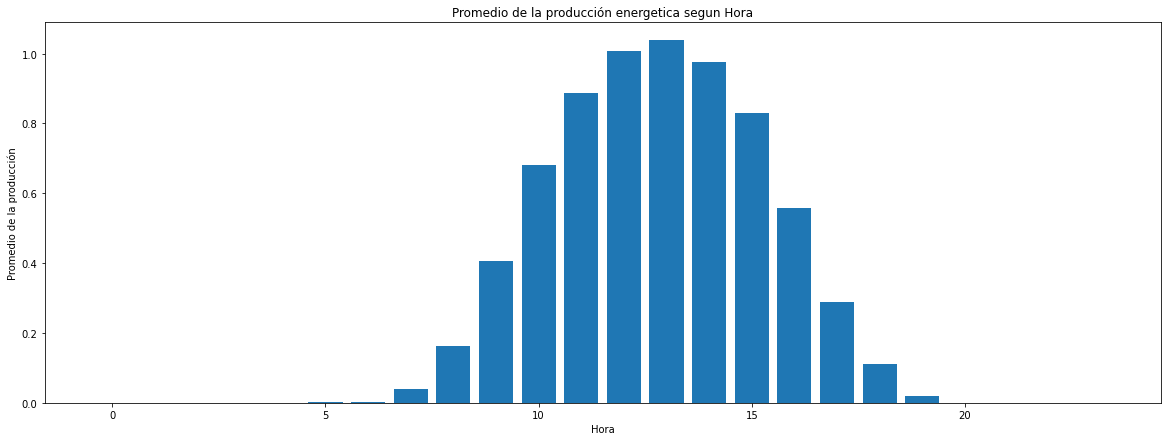

In [11]:
grafico_barras_promedio('Hora')

En este grafico de cajas veo lo mismo pero apreciando ademas la distribucion de la produccion energetica hora por hora.

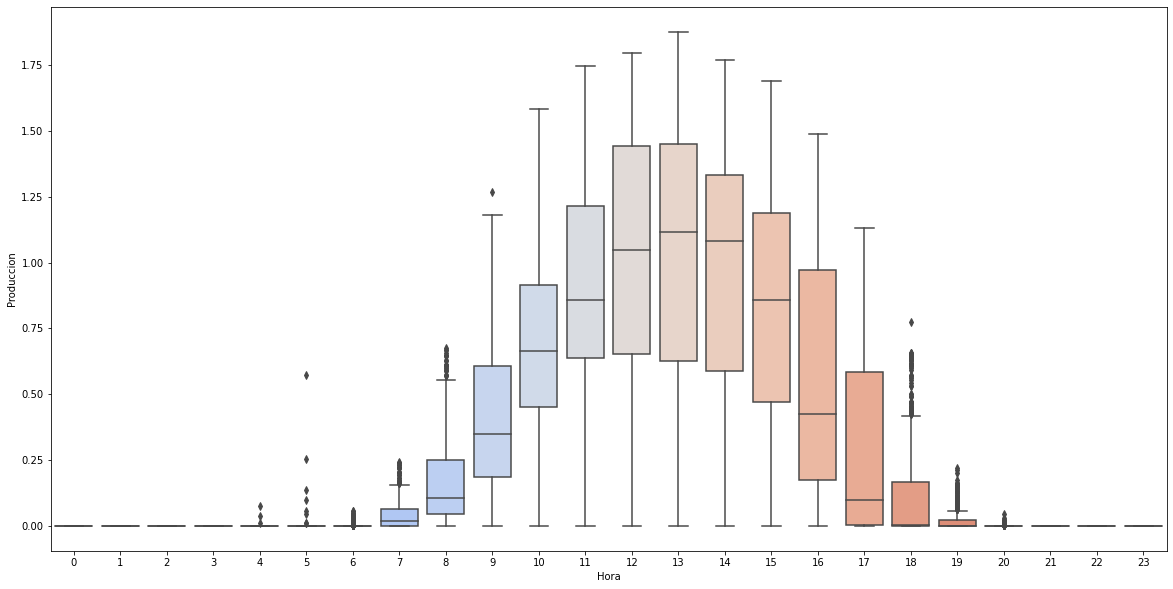

In [12]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='Hora', y='Produccion', data=df_join, palette='coolwarm')
plt.xticks(np.arange(24), range(24))
plt.show()


## Meses

Repito el mismo analisis para los meses y confirmo de manera visual que en invierno se produce menos energia y que en verano la produccion es maxima.

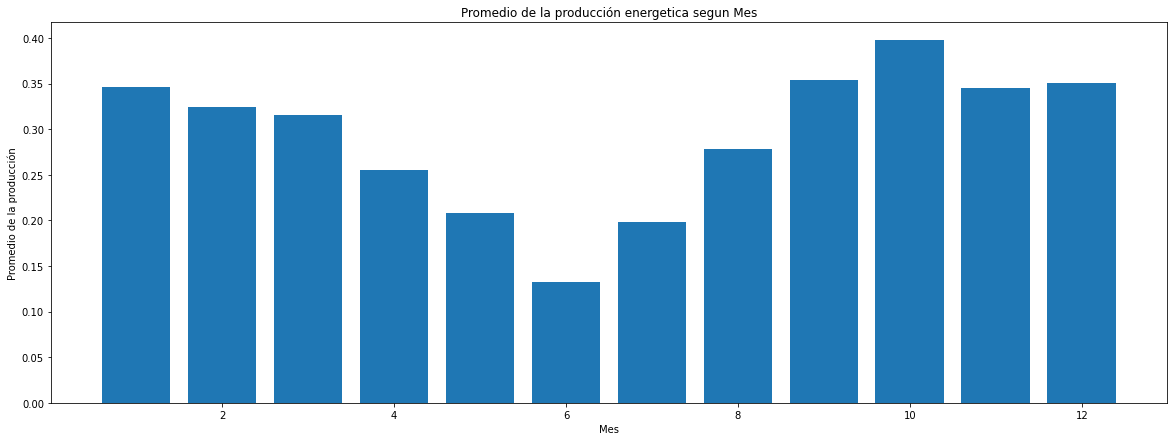

In [13]:
grafico_barras_promedio('Mes')

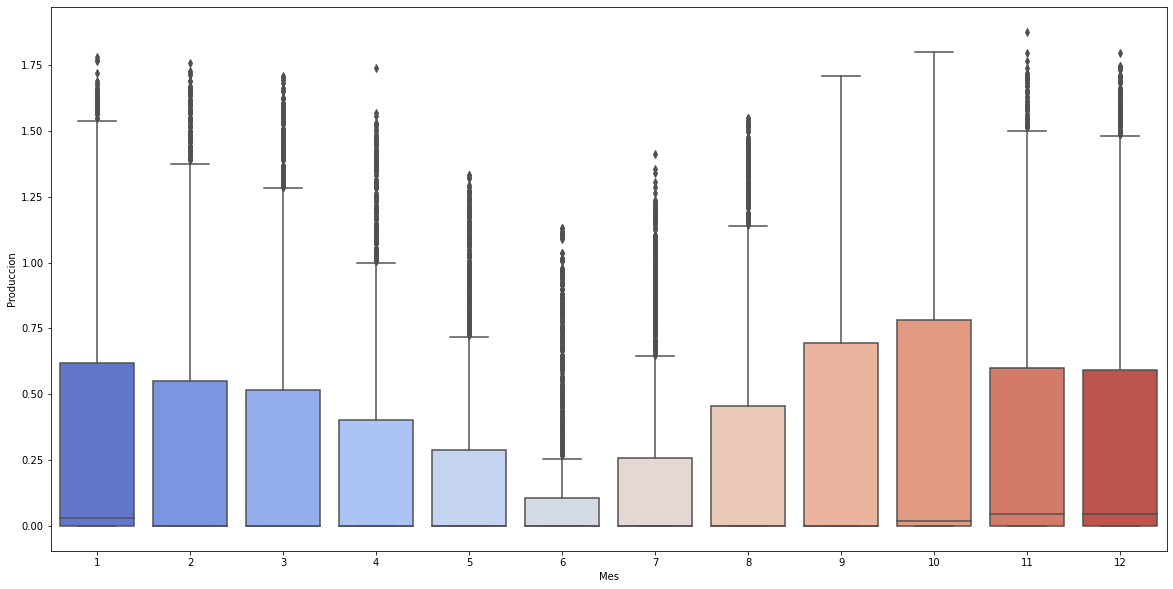

In [14]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='Mes', y='Produccion', data=df_join, palette='coolwarm')
plt.xticks(np.arange(12) , range(1, 13))
plt.show()

## Clima

Cuando esta soleado la produccion de energia aumenta, y se mantiene elevada para las categorias *scattered clouds* y *passing clouds*, por el contrario cuando es *Clear* casi no hay produccion

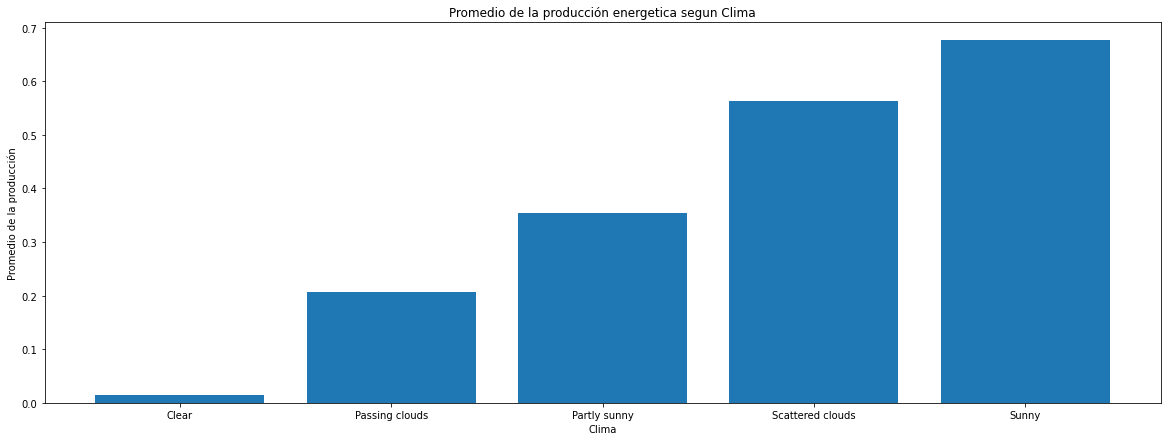

In [15]:
grafico_barras_promedio('Clima')

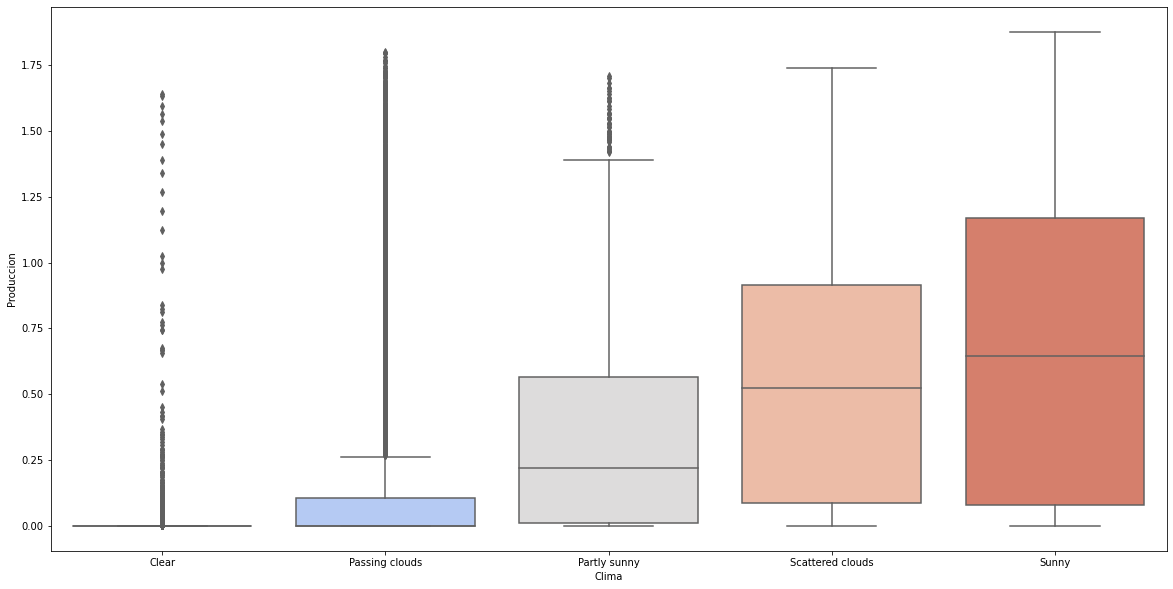

In [16]:
order = ['Clear', 'Passing clouds', 'Partly sunny', 'Scattered clouds', 'Sunny']

plt.figure(figsize=(20, 10))
sns.boxplot(x='Clima', y='Produccion', data=df_join, palette='coolwarm', order=order)
plt.show()

En el siguiente grafico se ve la relacion que hay entre el clima y la hora, mientras mas ocurrencia tenga un tipo de clima a una hora determinada mas rojo sera el recuadro.
y por lo que se ve *clear* solo ocurre de noche y tanto *Sunny*, *scattered clouds* y *partly sunny* ocurren durante las horas de luz, en cambio *passing clouds* puede ocurrir a cualquier hora del dia pero especialmente de noche


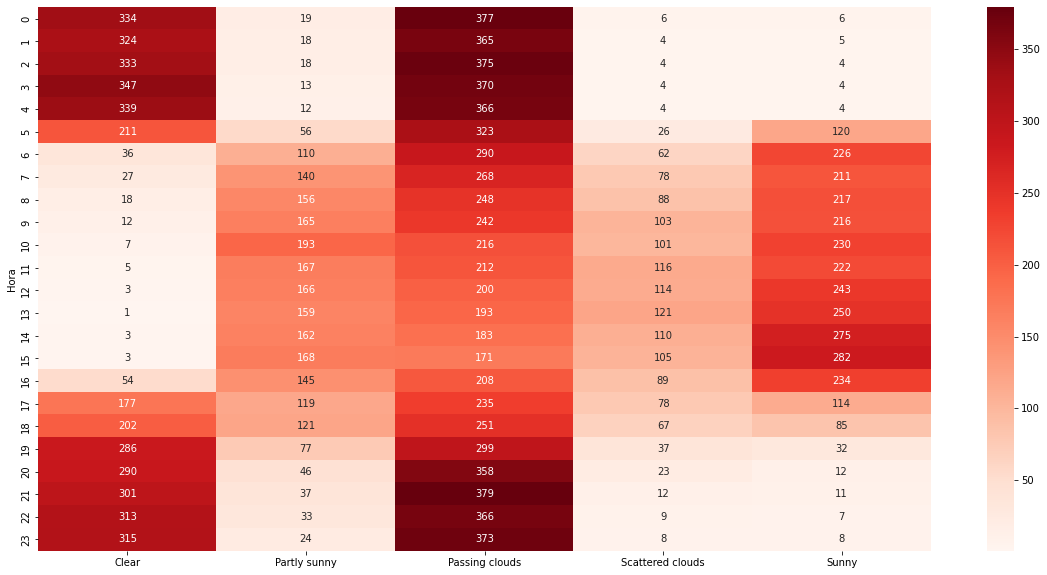

In [17]:
df_join_pivot = df_join.pivot_table(
    index=["Hora"],
    columns=["Clima"],
    values=["Produccion"],
    aggfunc="count"
)

df_join_pivot.columns = [col[1] for col in df_join_pivot.columns]

plt.figure(figsize=(20, 10))

sns.heatmap(df_join_pivot, annot=True, fmt="d",  cmap="Reds")

plt.show()

## Humedad

A priori pareceria que mientras menos humedad mas produccion de energia, por lo que seria una correlacion negativa

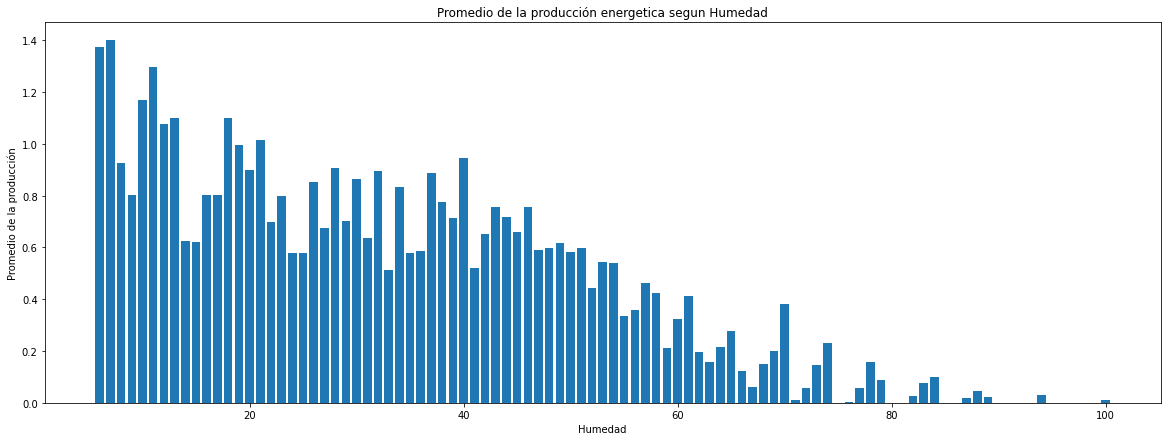

In [18]:
grafico_barras_promedio('Humedad')

## Viento

No parece haber una correlacion clara entre el viento y el promedio de produccion energetica

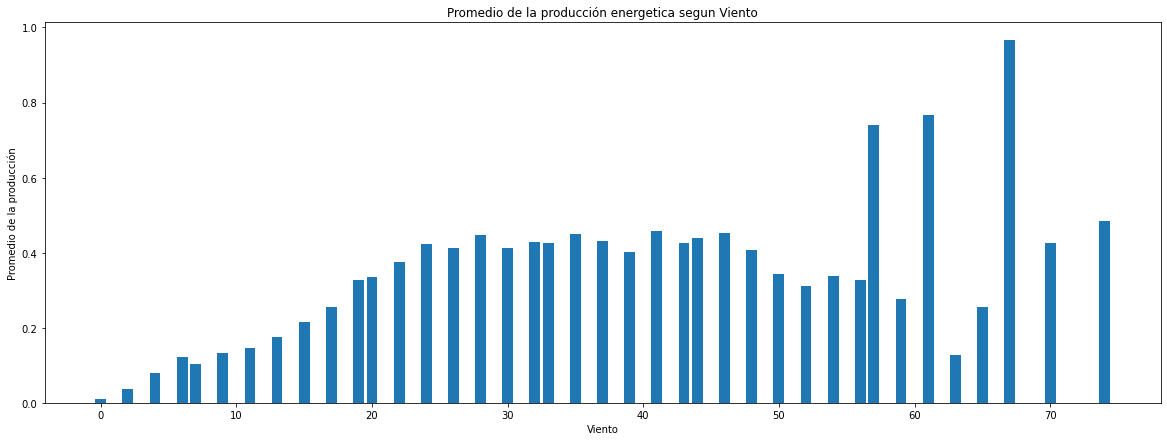

In [19]:
grafico_barras_promedio('Viento')

## Temperatura

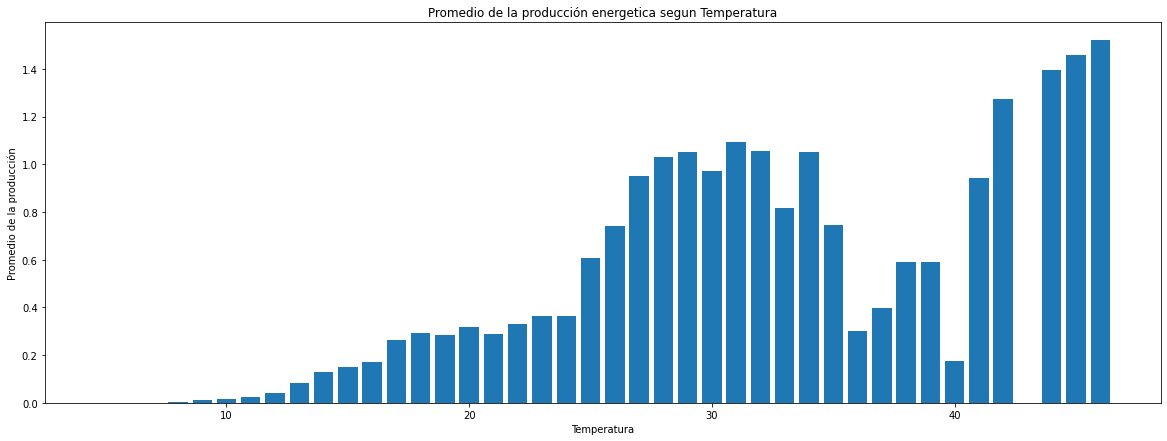

In [20]:
grafico_barras_promedio('Temperatura')

## Presion Atmosferica

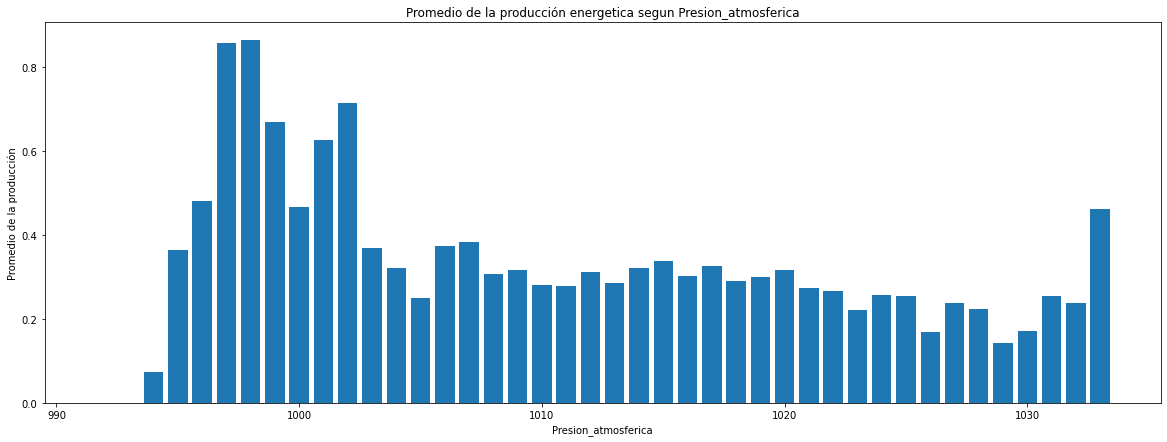

In [21]:
grafico_barras_promedio('Presion_atmosferica')

## Estacionalidad de la Serie

Analizar la estacionalidad de una serie temporal significa examinar los patrones repetitivos en la frecuencia de los datos en un período de tiempo específico, como días, meses o años. Esto puede incluir la identificación de tendencias y ciclos regulares, así como la detección de eventos puntuales, como picos o caídas en los datos.

A simple vista lo primero que se ve es que la serie esta formada por un monton de barras altas y bajas alternadamente, y que durante el verano de sidney es mas elevada la produccion y mas baja en invierno, lo cual tiene sentido.

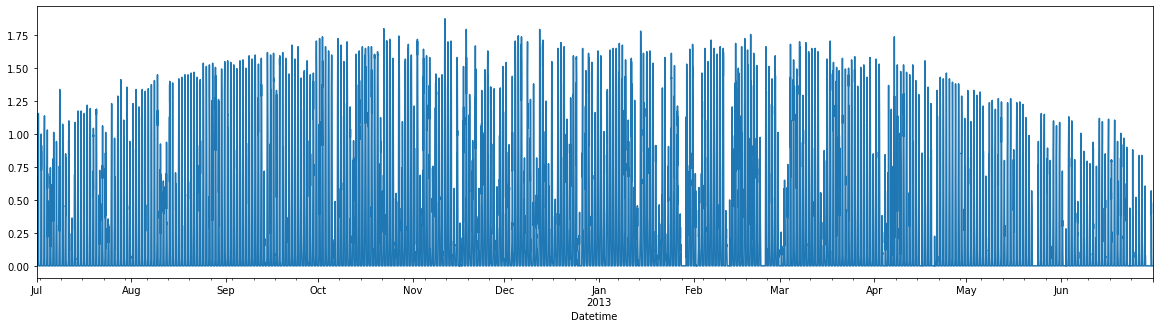

In [22]:
# grafico toda la serie completa
df_join.Produccion.plot(figsize = (20,5))

Haciendo lupa en un mes concreto se ve con muchisima mas claridad la perioricidad diaria de la serie.

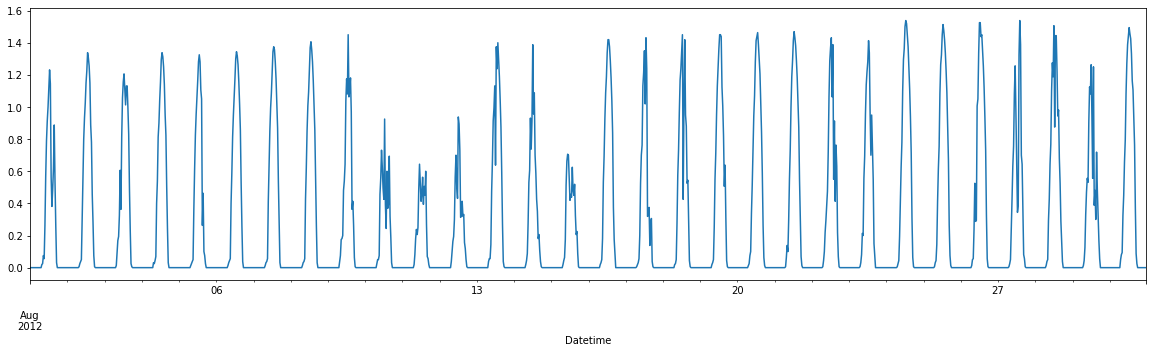

In [23]:
df_join.loc['2012-08-01 00:00:00':'2012-08-30 23:30:00'].Produccion.plot(figsize = (20,5))

Si vemos un dia en concreto se ve claramente que durante la noche no se genera energia y que en la medida de que el dia transcurre la produccion aumenta y decae nuevamente hacia la noche

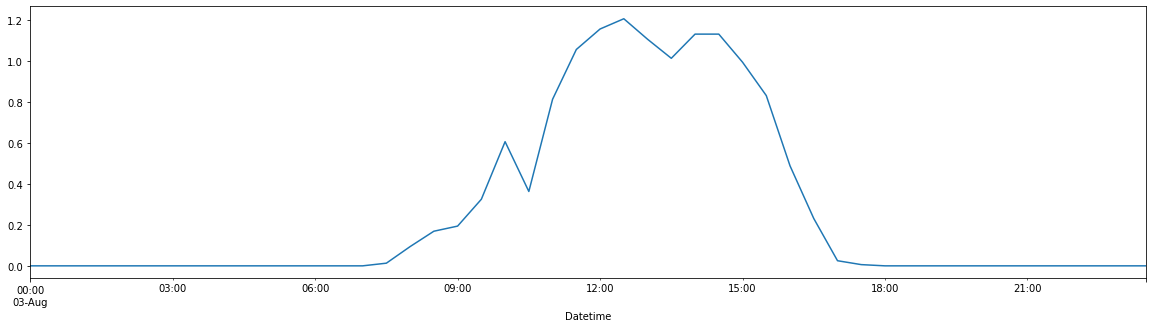

In [24]:
df_join.loc['2012-08-03 00:00:00':'2012-08-03 23:30:00'].Produccion.plot(figsize = (20,5))

### Prueba de Dickey-Fuller

El resultado del test ADF sugiere que la serie temporal es estacionaria.

El valor de la estadística ADF es -9.19, que es mucho menor que los valores críticos en el 1%, 5% y 10% de los niveles de significancia. Esto significa que podemos rechazar la hipótesis nula de que la serie temporal no es estacionaria con una confianza del 99%, 95% y 90%, respectivamente.

El valor de p-value es de 2.19e-15, que es extremadamente pequeño y mucho menor que el nivel de significancia del 5%. Esto significa que la hipótesis nula de no-estacionariedad es rechazada con una confianza del 95%.

Por lo tanto, podemos concluir que la serie temporal es estacionaria.

In [25]:
result = adfuller(df_join.Produccion)

print("ADF: ", result[0])
print("p-value: ", result[1])
print("nobs: ", result[2])
print("critical values: ", result[4])
print("usedlag: ", result[3])

ADF:  -9.185665718821259
p-value:  2.191164128519894e-15
nobs:  44
critical values:  {'1%': -3.4307242638530675, '5%': -2.861705410152796, '10%': -2.5668580435332715}
usedlag:  17475


<Figure size 1440x720 with 0 Axes>

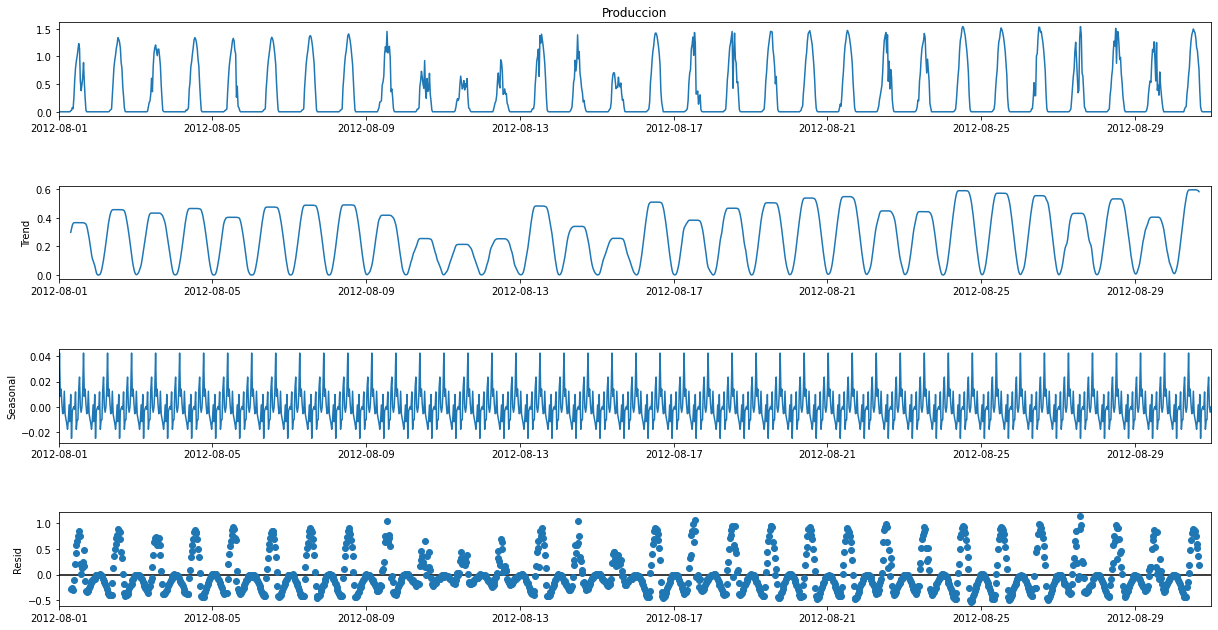

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

s_dec_additive = seasonal_decompose(df_join.Produccion.loc['2012-08-01 00:00:00':'2012-08-30 23:30:00'], model="additive", period=30)

plt.figure(figsize=(20, 10))
s_dec_additive.plot()
plt.gcf().set_size_inches(20, 10)
plt.show()





### Grafico de correlacion (ACF)

La función de autocorrelación (ACF, por sus siglas en inglés) es una medida de la correlación entre valores consecutivos de una serie temporal. En otras palabras, mide cuán relacionados están los valores de la serie en diferentes retrasos.

La ACF se representa gráficamente como una línea que muestra la correlación entre un valor de la serie y los valores que le preceden a un cierto número de períodos o retrasos (lag). Si la ACF muestra una tendencia clara a disminuir a medida que aumenta el lag, significa que la serie temporal es estacionaria y que los valores futuros están correlacionados con los valores pasados.

La ACF es útil para determinar la cantidad de autorregresión en una serie temporal y para seleccionar los valores adecuados de los parámetros p, d y q en un modelo de series temporales, como el modelo ARIMA.

La forma senoidal de esta grafica indica que hay una perioricidad en los datos, y dado que los intervalos son de media hora y que justo a los 48 intervalos se produce un ciclo completo, lo puedo interpretar como que de dia la produccion va subiendo y que en la medida que se hace de noche la produccion decrece.

<Figure size 1440x720 with 0 Axes>

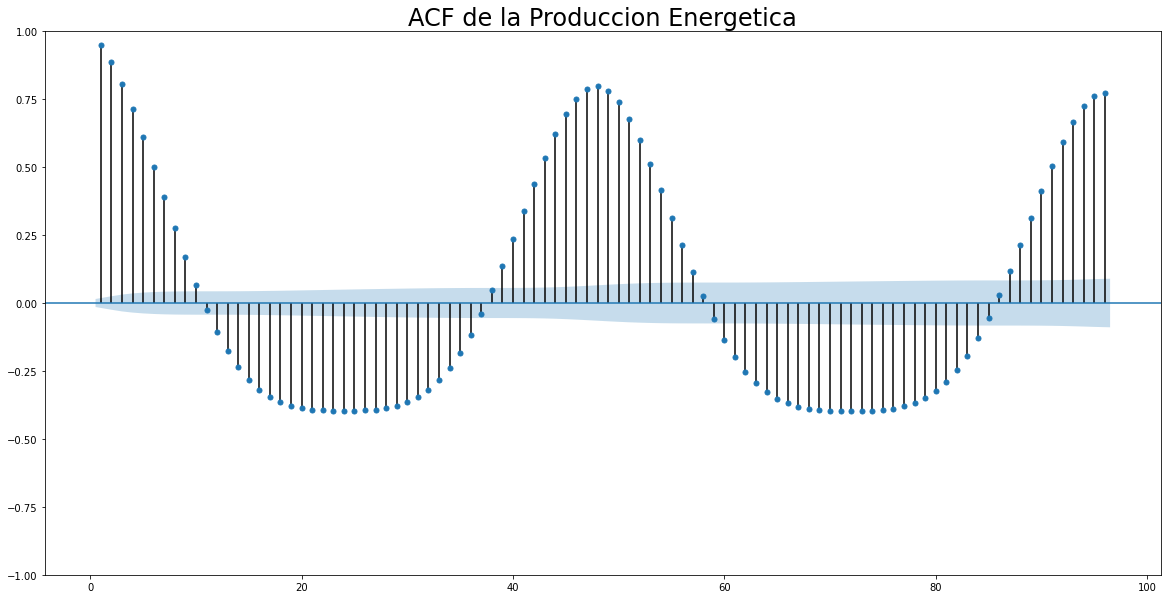

In [27]:
plt.figure(figsize=(20,10))
sgt.plot_acf(df_join.Produccion, lags = (24 * 2 * 2), zero = False)
plt.title("ACF de la Produccion Energetica", size = 24)
plt.gcf().set_size_inches(20, 10)
plt.show()


### Grafico de autocorrelación parcial (PACF) 
La función de autocorrelación parcial (PACF) es una variante de la ACF que mide la correlación entre un valor de la serie y los valores que le preceden, después de controlar por los valores intermedios. Ambas funciones son importantes para comprender la estructura de la serie temporal y para construir modelos precisos.

Este grafico me indica que para predecir puedo usar aproximadamente entre 48 y 54 ciclos

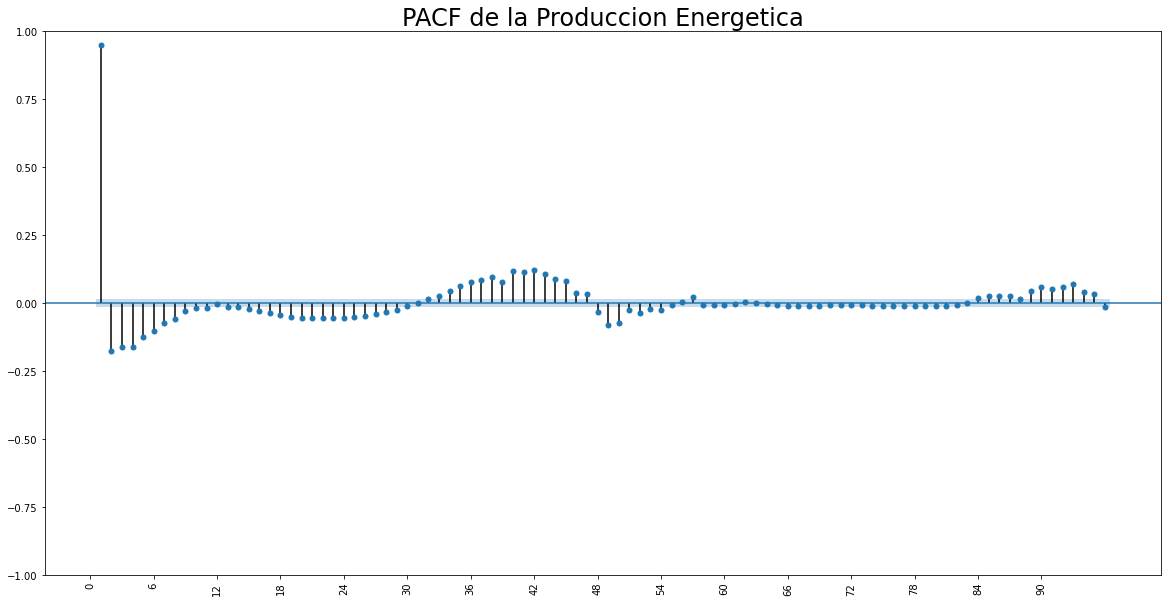

In [28]:
sgt.plot_pacf(df_join.Produccion, lags = (24 * 2 * 2), zero = False, method = ('ols'))
plt.xticks(np.arange(0, 24*2*2, 6), rotation=90)

plt.title("PACF de la Produccion Energetica", size = 24)
plt.gcf().set_size_inches(20, 10)

plt.show()

# Modelos

Separo mi conjunto de datos en train y test

In [69]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse


# guardo 1 semana de datos para testear
split = len(df_join) - (48 * 7)

df_train = df_join[:split]
df_test = df_join[split:]

print(df_train.tail(2).index)
print(df_test.head(2).index)

DatetimeIndex(['2013-06-23 23:00:00', '2013-06-23 23:30:00'], dtype='datetime64[ns]', name='Datetime', freq='30T')
DatetimeIndex(['2013-06-24 00:00:00', '2013-06-24 00:30:00'], dtype='datetime64[ns]', name='Datetime', freq='30T')


## Media constante

<ipython-input-70-d671d495d136>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["ProduccionMean"] = model_mean_pred


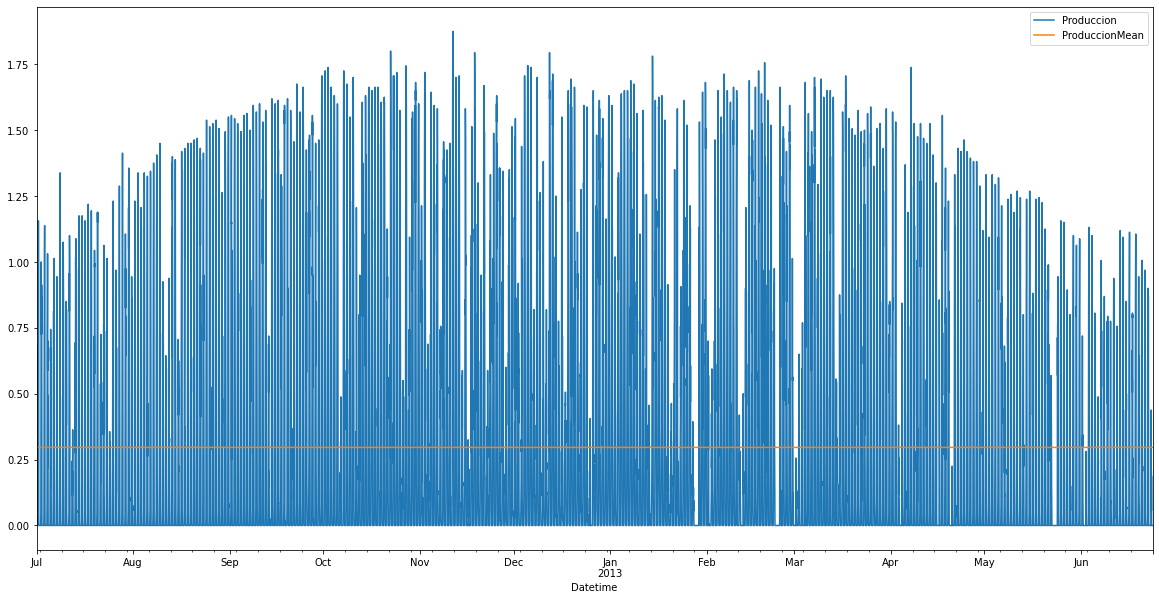

In [70]:
model_mean_pred = df_train.Produccion.mean()
df_train["ProduccionMean"] = model_mean_pred

df_train.plot(kind="line", y = ["Produccion", "ProduccionMean"], figsize=(20,10));

Guardo el resultado en una tabla para luego hacer una comparacion entre los modelos.

In [71]:
model_mean_RMSE = RMSE(df_train.ProduccionMean, df_train.Produccion)

# Guardamos todo en un dataframe
dfModelsResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
dfModelsResults.loc[0,"Model"] = "Mean"
dfModelsResults.loc[0,"Forecast"] = model_mean_pred
dfModelsResults.loc[0,"RMSE"] = model_mean_RMSE
dfModelsResults.head()

,Model,Forecast,RMSE
0,Mean,0.29628,0.466129


Agrego una columna que le proporcione un orden a los registros comenzando por 0 e incrementandose de 1 en 1

In [72]:
# Agrego una columna que le de un orden a los registros comenzando por 0 e incrementandose de 1 en 1
df_train["timeIndex"] = df_train.index - df_train.index.min()
df_train["timeIndex"] =  df_train["timeIndex"]/np.timedelta64(30, 'm')
df_train["timeIndex"] = df_train["timeIndex"].round(0).astype(int)
df_train.head()

<ipython-input-72-ac66412eb7e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["timeIndex"] = df_train.index - df_train.index.min()
<ipython-input-72-ac66412eb7e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["timeIndex"] =  df_train["timeIndex"]/np.timedelta64(30, 'm')
<ipython-input-72-ac66412eb7e7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,Produccion,Temperatura,Clima,Viento,Humedad,Presion_atmosferica,Visibilidad,Clear,Partly_sunny,Passing_clouds,Scattered_clouds,Sunny,Hora,Mes,ProduccionMean,timeIndex
Datetime,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,0.0,12,Clear,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7,0.29628,0
2012-07-01 00:30:00,0.0,12,Clear,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7,0.29628,1
2012-07-01 01:00:00,0.0,12,Clear,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7,0.29628,2
2012-07-01 01:30:00,0.0,12,Clear,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7,0.29628,3
2012-07-01 02:00:00,0.0,12,Clear,7,54,1014,16,1.0,0.0,0.0,0.0,0.0,2,7,0.29628,4


## Regresion Lineal

In [73]:
model_linear = smf.ols('Produccion ~ timeIndex', data = df_train).fit()
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Produccion   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     43.21
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           5.06e-11
Time:                        02:52:54   Log-Likelihood:                -11245.
No. Observations:               17184   AIC:                         2.249e+04
Df Residuals:                   17182   BIC:                         2.251e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3367      0.007     47.405      0.000       0.323       0.351
timeIndex  -4.706e-06   7.16e-07     -6.573      0.000   -6.11e-06    -3.3e-06
==============================================================================
Omnibus:                     3732.662   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6652.326
Skew:                           1.461   Prob(JB):                         0.00
Kurtosis:                       3.865   Cond. No.                     1.98e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
model_linear_pred = model_linear.predict()
model_linear_pred[:10]

array([0.33671321, 0.33670851, 0.3367038 , 0.3366991 , 0.33669439,
       0.33668968, 0.33668498, 0.33668027, 0.33667556, 0.33667086])

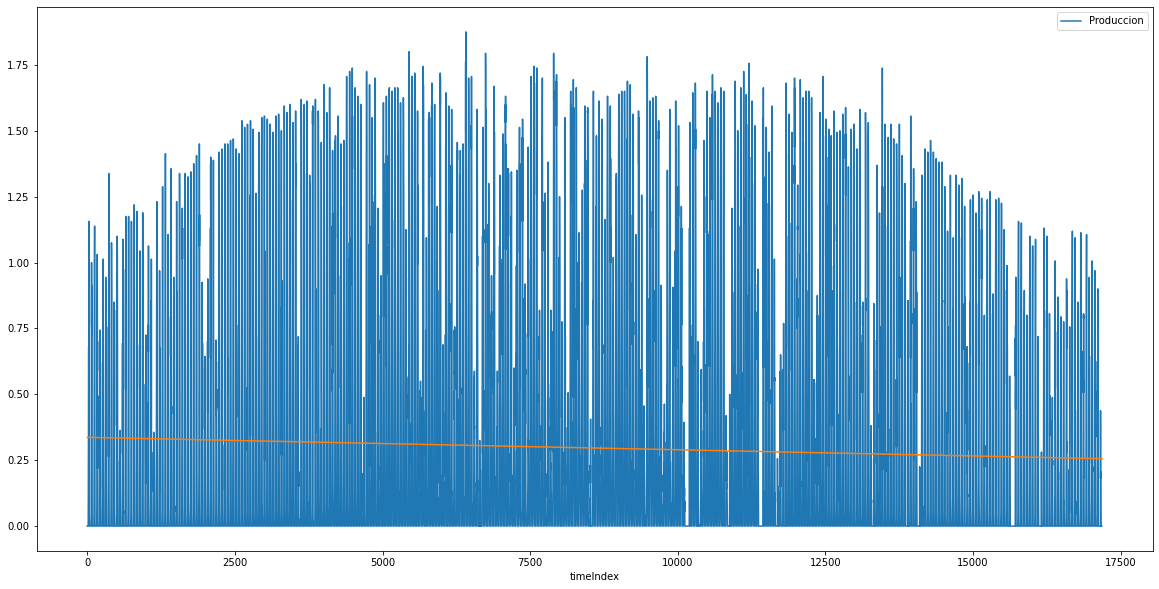

In [75]:
df_train.plot(kind="line", x="timeIndex", y = "Produccion", figsize=(20,10))
plt.plot(df_train.timeIndex,model_linear_pred, '-')

In [ ]:
# Ploteamos los residuos de nuestra estimación
#model_linear.resid.plot(kind = "bar");

In [76]:
df_train["ProduccionLinear"] = model_linear_pred
df_train.head()

<ipython-input-76-ce228a63fc21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["ProduccionLinear"] = model_linear_pred


,Produccion,Temperatura,Clima,Viento,Humedad,Presion_atmosferica,Visibilidad,Clear,Partly_sunny,Passing_clouds,Scattered_clouds,Sunny,Hora,Mes,ProduccionMean,timeIndex,ProduccionLinear
Datetime,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,0.0,12,Clear,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7,0.29628,0,0.336713
2012-07-01 00:30:00,0.0,12,Clear,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7,0.29628,1,0.336709
2012-07-01 01:00:00,0.0,12,Clear,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7,0.29628,2,0.336704
2012-07-01 01:30:00,0.0,12,Clear,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7,0.29628,3,0.336699
2012-07-01 02:00:00,0.0,12,Clear,7,54,1014,16,1.0,0.0,0.0,0.0,0.0,2,7,0.29628,4,0.336694


In [77]:
# Root Mean Squared Error (RMSE)
model_linear_RMSE = RMSE(df_train.ProduccionLinear, df_train.Produccion)

# Añadimos estos datos a nuestro DF de resultados para comparar con el modelo anterior
dfModelsResults.loc[1,"Model"] = "Linear"
dfModelsResults.loc[1,"Forecast"] = model_linear_pred
dfModelsResults.loc[1,"RMSE"] = model_linear_RMSE
dfModelsResults.head()

,Model,Forecast,RMSE
0,Mean,0.29628,0.466129
1,Linear,"[0.3367132138197586, 0.3367085075808671, 0.336...",0.465544


## Linear + Variables endogenas

In [79]:
# Ahora estimamos una variante del modelo lineal, incluyendo las variables endogenas
model_linear_endogenas = smf.ols('Produccion ~ timeIndex + Viento + Humedad + Presion_atmosferica + Visibilidad + Clear  + Partly_sunny + Passing_clouds + Scattered_clouds + Sunny + Hora + Mes', data = df_train).fit()
model_linear_endogenas.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Produccion   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1131.
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        02:54:18   Log-Likelihood:                -6585.5
No. Observations:               17184   AIC:                         1.320e+04
Df Residuals:                   17172   BIC:                         1.329e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.1097      0.399     -2.781      0.005      -1.892      -0.328
timeIndex            3.936e-06   6.54e-07      6.021      0.000    2.65e-06    5.22e-06
Viento                  0.0028      0.000      9.525      0.000       0.002       0.003
Humedad                -0.0123      0.000    -62.726      0.000      -0.013      -0.012
Presion_atmosferica     0.0024      0.000      5.067      0.000       0.001       0.003
Visibilidad            -0.0007      0.001     -0.767      0.443      -0.002       0.001
Clear                  -0.5477      0.079     -6.893      0.000      -0.703      -0.392
Partly_sunny           -0.1641      0.080     -2.051      0.040      -0.321      -0.007
Passing_clouds         -0.2991      0.081     -3.712      0.000      -0.457      -0.141
Scattered_clouds       -0.0208      0.081     -0.257      0.797      -0.180       0.138
Sunny                  -0.0779      0.079     -0.984      0.325      -0.233       0.077
Hora                   -0.0008      0.000     -2.012      0.044      -0.002   -2.12e-05
Mes                    -0.0009      0.001     -0.989      0.323      -0.003       0.001
==============================================================================
Omnibus:                     2426.432   Durbin-Watson:                   0.237
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3928.842
Skew:                           0.972   Prob(JB):                         0.00
Kurtosis:                       4.308   Cond. No.                     2.05e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.05e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [80]:
df_train["ProduccionLinearEndogenas"] = model_linear_endogenas.predict()
model_linear_endogenas.params

<ipython-input-80-07afc41b61d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["ProduccionLinearEndogenas"] = model_linear_endogenas.predict()


Intercept             -1.109718
timeIndex              0.000004
Viento                 0.002802
Humedad               -0.012276
Presion_atmosferica    0.002370
Visibilidad           -0.000661
Clear                 -0.547695
Partly_sunny          -0.164150
Passing_clouds        -0.299119
Scattered_clouds      -0.020821
Sunny                 -0.077933
Hora                  -0.000828
Mes                   -0.000903
dtype: float64

In [81]:
model_linear_endogenas_pred = model_linear_endogenas.predict()
model_linear_endogenas_pred[:10]

array([ 0.0970023 ,  0.09700623,  0.09057914,  0.09058308,  0.08415598,
       -0.08944074,  0.00193366,  0.0019376 , -0.12058007, -0.07147055])

In [82]:
dfModelsResults.loc[2,"Model"] = "LinearEndogenas"
dfModelsResults.loc[2,"Forecast"] = model_linear_endogenas_pred
dfModelsResults.loc[2,"RMSE"] = RMSE(df_train.ProduccionLinearEndogenas, df_train.Produccion)
dfModelsResults.head()

,Model,Forecast,RMSE
0,Mean,0.29628,0.466129
1,Linear,"[0.3367132138197586, 0.3367085075808671, 0.336...",0.465544
2,LinearEndogenas,"[0.09700229847730096, 0.09700623429132377, 0.0...",0.354977


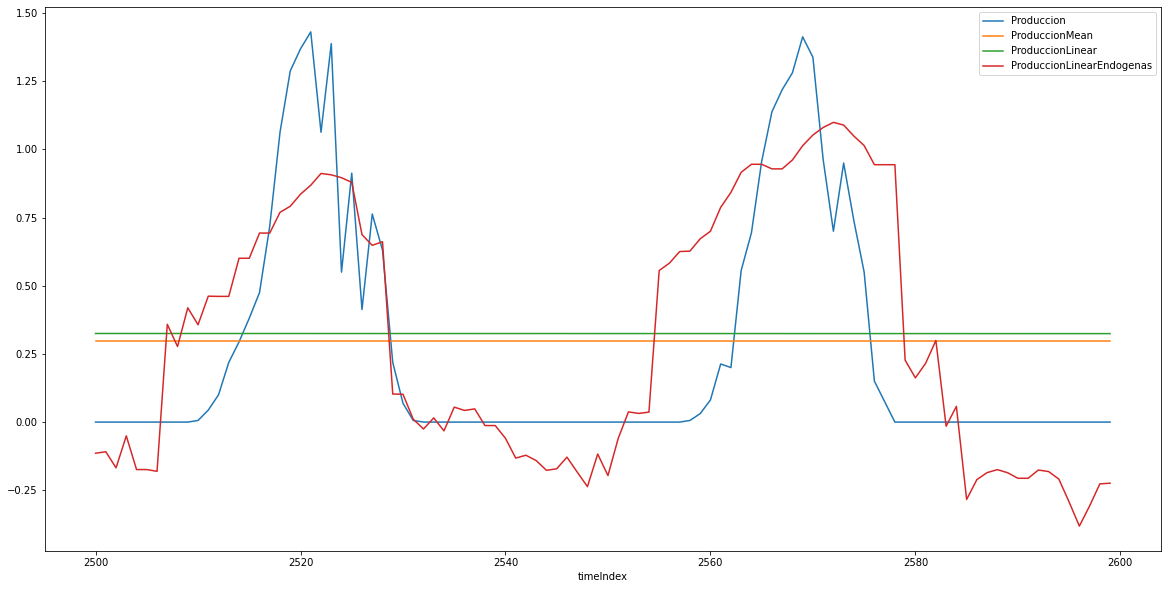

In [83]:
df_train[2500:2600].plot(kind="line", x="timeIndex", y = ["Produccion", "ProduccionMean", 
                                             "ProduccionLinear", "ProduccionLinearEndogenas"], figsize=(20,10));

## Media Movil - SMA (Simple Moving Averange)

<ipython-input-84-0619abe9958e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ProduccionSMA48'] = df_train.Produccion.rolling(window = 48).mean()


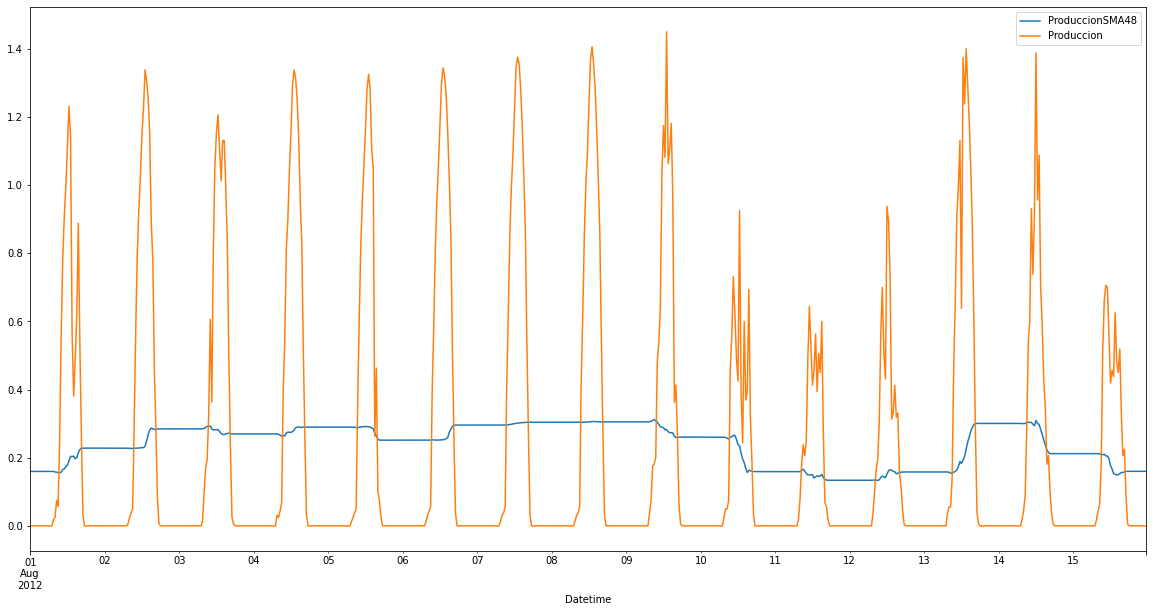

In [84]:
# Calculamos la media móvil de 12 meses para suavizar los valores y ploteamos
df_train['ProduccionSMA48'] = df_train.Produccion.rolling(window = 48).mean()
df_train.loc['2012-08-01 00:00:00':'2012-08-15 23:30:00'].plot(kind ="line", y=["ProduccionSMA48", "Produccion"], figsize=(20,10));

In [ ]:
dfModelsResults.loc[3,"Model"] = "SMA48"
dfModelsResults.loc[3,"Forecast"] =  0
dfModelsResults.loc[3,"RMSE"] = RMSE(df_train.ProduccionSMA48, df_train.Produccion)
dfModelsResults.head()

## Media movil exponencial - EWMA (exponentially weighted moving average)

<ipython-input-112-aae6e2c55ee3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ProduccionEWMA48'] = df_train.Produccion.ewm(span = 48, adjust=False).mean()


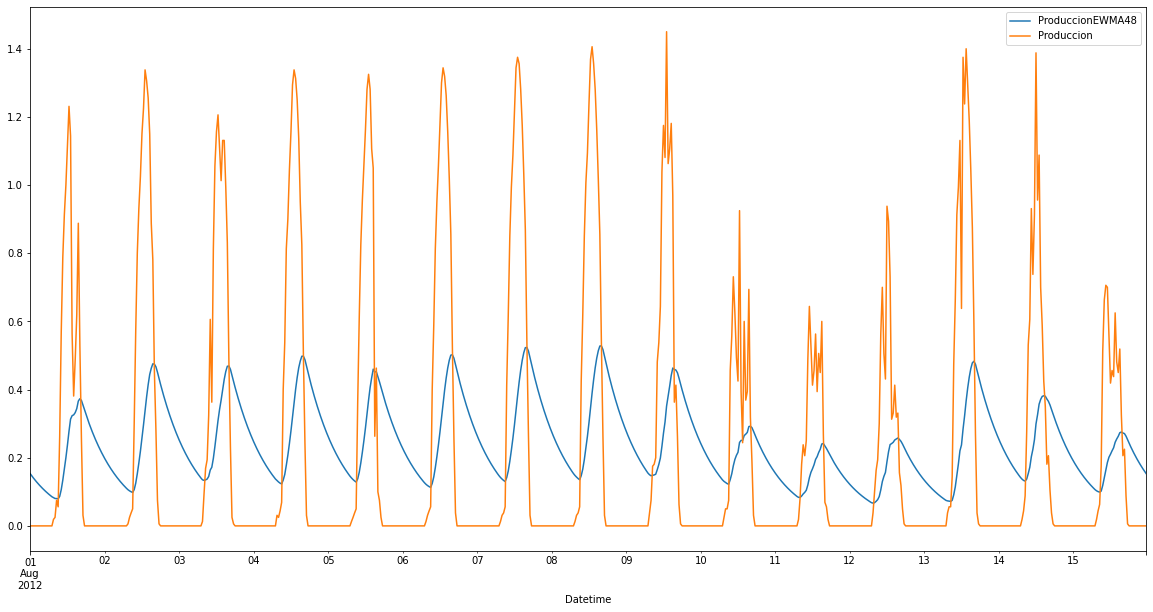

In [112]:
df_train['ProduccionEWMA48'] = df_train.Produccion.ewm(span = 48, adjust=False).mean()
df_train.loc['2012-08-01 00:00:00':'2012-08-15 23:30:00'].plot(kind ="line", y=["ProduccionEWMA48", "Produccion"], figsize=(20,10));

In [113]:
dfModelsResults.loc[4,"Model"] = "EWMA48"
dfModelsResults.loc[4,"Forecast"] =  0
dfModelsResults.loc[4,"RMSE"] = RMSE(df_train.ProduccionEWMA48, df_train.Produccion)
dfModelsResults.head()

,Model,Forecast,RMSE
0,Mean,0.29628,0.466129
1,Linear,"[0.3367132138197586, 0.3367085075808671, 0.336...",0.465544
2,LinearEndogenas,"[0.09700229847730096, 0.09700623429132377, 0.0...",0.354977
3,SMA48,0,0.456466
4,EWMA48,0,0.427165


## Suavisado exponencial doble

<ipython-input-126-b5856e0b85a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['DESadd'] = ExponentialSmoothing(df_train['Produccion'], trend='add', seasonal='add', seasonal_periods=48).fit().fittedvalues


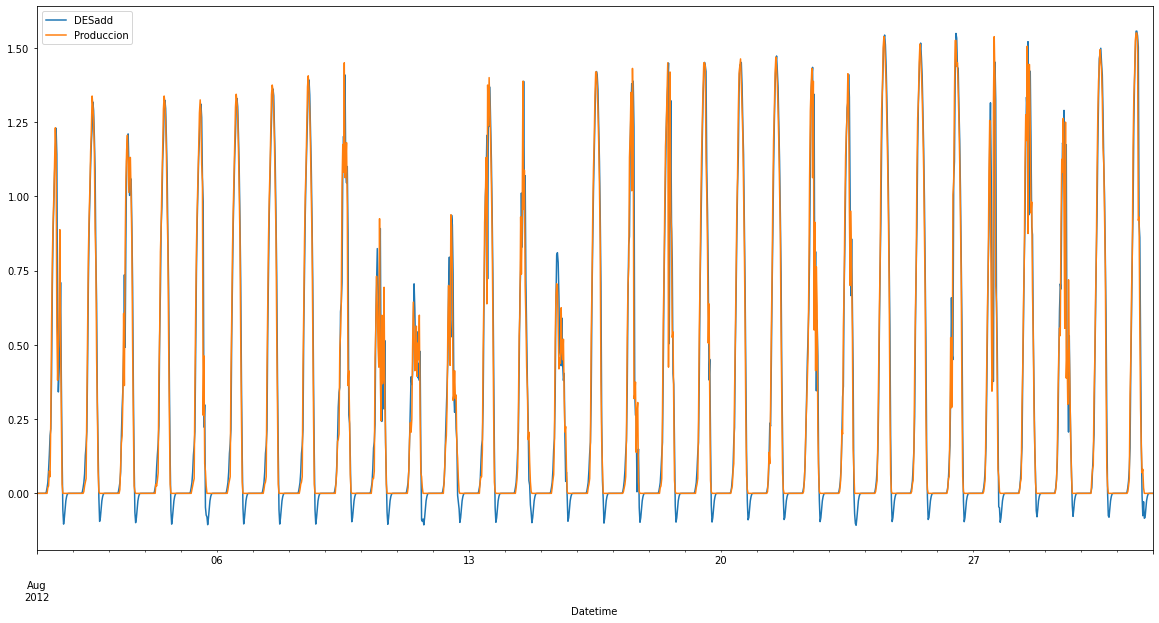

In [126]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df_train['DESadd'] = ExponentialSmoothing(df_train['Produccion'], trend='add', seasonal='add', seasonal_periods=48).fit().fittedvalues
df_train.loc['2012-08-01 00:00:00':'2012-08-31 23:30:00'].plot(kind='line', y=["DESadd", "Produccion"], figsize=(20,10))

## ARIMA

In [ ]:
columns_exog = ['Temperatura', 'Viento', 'Humedad',
       'Presion_atmosferica', 'Visibilidad', 'Clear', 'Partly sunny',
       'Passing clouds', 'Scattered clouds', 'Sunny', 'Hora', 'Mes']

df_train[columns_exog]

,Temperatura,Viento,Humedad,Presion_atmosferica,Visibilidad,Clear,Partly sunny,Passing clouds,Scattered clouds,Sunny,Hora,Mes
Datetime,,,,,,,,,,,,
2012-07-01 00:00:00,12,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7
2012-07-01 00:30:00,12,11,54,1014,16,1.0,0.0,0.0,0.0,0.0,0,7
2012-07-01 01:00:00,12,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7
2012-07-01 01:30:00,12,9,54,1014,16,1.0,0.0,0.0,0.0,0.0,1,7
2012-07-01 02:00:00,12,7,54,1014,16,1.0,0.0,0.0,0.0,0.0,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-23 21:30:00,13,32,77,1026,9,0.0,0.0,1.0,0.0,0.0,21,6
2013-06-23 22:00:00,13,15,82,1026,9,0.0,0.0,1.0,0.0,0.0,22,6
2013-06-23 22:30:00,12,9,94,1026,6,0.0,0.0,1.0,0.0,0.0,22,6


In [ ]:
model_ar_1_i_1_ma_1_Xspx = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog], order=(1,1,1))
results_ar_1_i_1_ma_1_Xspx = model_ar_1_i_1_ma_1_Xspx.fit()
results_ar_1_i_1_ma_1_Xspx.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:                 ARIMA(1, 1, 1)   Log Likelihood                8938.071
Date:                Wed, 08 Feb 2023   AIC                         -17846.142
Time:                        03:38:55   BIC                         -17729.867
Sample:                    07-01-2012   HQIC                        -17807.819
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Temperatura             0.0343      0.002     18.898      0.000       0.031       0.038
Viento                  0.0012      0.000      4.276      0.000       0.001       0.002
Humedad                 0.0018      0.000      5.574      0.000       0.001       0.002
Presion_atmosferica    -0.0087      0.002     -3.838      0.000      -0.013      -0.004
Visibilidad            -0.0009      0.001     -0.657      0.511      -0.004       0.002
Clear                  -0.0094      0.008     -1.156      0.248      -0.025       0.007
Partly sunny           -0.0293      0.004     -7.432      0.000      -0.037      -0.022
Passing clouds         -0.0014      0.004     -0.380      0.704      -0.009       0.006
Scattered clouds       -0.0005      0.003     -0.152      0.879      -0.007       0.006
Sunny                   0.0373      0.004      8.970      0.000       0.029       0.045
Hora                -4.763e-05      0.001     -0.036      0.971      -0.003       0.003
Mes                    -0.0034      0.044     -0.079      0.937      -0.089       0.082
ar.L1                   0.2440      0.036      6.804      0.000       0.174       0.314
ma.L1                  -0.1348      0.035     -3.811      0.000      -0.204      -0.065
sigma2                  0.0206      0.000    205.491      0.000       0.020       0.021
===================================================================================
Ljung-Box (L1) (Q):                  14.87   Jarque-Bera (JB):             76517.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.77e+17. Standard errors may be unstable.
"""

In [ ]:
model_ar_48_i_0_ma_48_Xspx = sm.tsa.arima.ARIMA(df_train.Produccion, exog = df_train[columns_exog], order=(48,0,48))
results_ar_48_i_0_ma_48_Xspx = model_ar_48_i_0_ma_48_Xspx.fit()
results_ar_48_i_0_ma_48_Xspx.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Produccion   No. Observations:                17184
Model:               ARIMA(48, 0, 48)   Log Likelihood              -24816.809
Date:                Wed, 08 Feb 2023   AIC                          49853.618
Time:                        06:55:24   BIC                          50706.308
Sample:                    07-01-2012   HQIC                         50134.656
                         - 06-23-2013                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -8.5590      0.093    -91.838      0.000      -8.742      -8.376
Temperatura             0.0284      0.000    197.151      0.000       0.028       0.029
Viento                  0.0031   5.84e-05     53.016      0.000       0.003       0.003
Humedad                -0.0105    4.1e-05   -256.483      0.000      -0.011      -0.010
Presion_atmosferica     0.0105      0.000     97.367      0.000       0.010       0.011
Visibilidad            -0.0006      0.000     -3.652      0.000      -0.001      -0.000
Clear                  -1.9698      0.018   -107.222      0.000      -2.006      -1.934
Partly sunny           -1.6759      0.019    -89.462      0.000      -1.713      -1.639
Passing clouds         -1.7876      0.019    -94.688      0.000      -1.825      -1.751
Scattered clouds       -1.5398      0.019    -81.577      0.000      -1.577      -1.503
Sunny                  -1.5859      0.019    -85.337      0.000      -1.622      -1.549
Hora                   -0.0044      0.000    -30.441      0.000      -0.005      -0.004
Mes                     0.0062      0.000     40.129      0.000       0.006       0.007
ar.L1                1.931e-07      0.002      0.000      1.000      -0.003       0.003
ar.L2                1.688e-07      0.002      0.000      1.000      -0.003       0.003
ar.L3                1.447e-07      0.002    8.9e-05      1.000      -0.003       0.003
ar.L4                1.198e-07      0.002   7.31e-05      1.000      -0.003       0.003
ar.L5                9.531e-08      0.002   5.72e-05      1.000      -0.003       0.003
ar.L6                7.076e-08      0.002   4.03e-05      1.000      -0.003       0.003
ar.L7                4.777e-08      0.002   2.65e-05      1.000      -0.004       0.004
ar.L8                2.697e-08      0.002   1.44e-05      1.000      -0.004       0.004
ar.L9                 1.05e-08      0.002   5.32e-06      1.000      -0.004       0.004
ar.L10              -2.115e-09      0.002  -1.04e-06      1.000      -0.004       0.004
ar.L11              -1.129e-08      0.002  -5.37e-06      1.000      -0.004       0.004
ar.L12               -1.69e-08      0.002  -7.81e-06      1.000      -0.004       0.004
ar.L13              -1.995e-08      0.002  -9.01e-06      1.000      -0.004       0.004
ar.L14              -2.037e-08      0.002  -8.81e-06      1.000      -0.005       0.005
ar.L15              -1.917e-08      0.002  -8.11e-06      1.000      -0.005       0.005
ar.L16              -1.636e-08      0.002  -6.73e-06      1.000      -0.005       0.005
ar.L17              -1.283e-08      0.002  -5.19e-06      1.000      -0.005       0.005
ar.L18              -9.373e-09      0.003  -3.65e-06      1.000      -0.005       0.005
ar.L19              -5.714e-09      0.003  -2.14e-06      1.000      -0.005       0.005
ar.L20              -2.524e-09      0.003  -9.33e-07      1.000      -0.005       0.005
ar.L21               6.847e-11      0.003    2.5e-08      1.000      -0.0